### Step 1: Run preliminary imports, set directories, etc.

In [1]:
import numpy as np
import pandas as pd
import sys, copy, requests, time, json
from pdastro import pdastrostatsclass, AandB, AnotB, AorB, not_AandB

# for interactive sliders, etc.
from ipywidgets import interact, interactive, fixed, interact_manual

# for getting discovery date from TNS
from lxml import html
from collections import OrderedDict
from astropy.time import Time

# plotting
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pylab as matlib
import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times'

# ATLAS template changes
global tchange1
global tchange2
tchange1 = 58417
tchange2 = 58882

#https://towardsdatascience.com/5-powerful-tricks-to-visualize-your-data-with-matplotlib-16bc33747e05

def dataPlot(x, y, dx=None, dy=None, sp=None, label=None, fmt='bo', ecolor='k', elinewidth=None, barsabove = False, capsize=1, logx=False, logy=False):
    if sp == None:
        sp = matlib.subplot(111)
    if dx is None and dy is None:
        if logy:
            if logx:
                plot, = sp.loglog(x, y, fmt)
            else:
                plot, = sp.semilogy(x, y, fmt)
        elif logx:
            plot, = sp.semilogx(x, y, fmt)
        else:
            if barsabove:
                plot, dplot,dummy = sp.errorbar(x, y, label=label, fmt=fmt, capsize=capsize, barsabove=barsabove)
            else:
                plot, = sp.plot(x, y, fmt)
        return sp, plot, None
    else:
        if logy:
            sp.set_yscale("log", nonposx='clip')
        if logx:
            sp.set_xscale("log", nonposx='clip')
        plot, dplot, dummy = sp.errorbar(x, y, xerr=dx, yerr=dy, label=label, fmt=fmt, ecolor=ecolor, elinewidth=elinewidth, capsize=capsize, barsabove=barsabove)
        return sp, plot, dplot

lc_info = pdastrostatsclass()

In [2]:
# Enter your data directory (where the SN light curves are located) here:
global dir
dir = '/Users/sofiarest/Google Drive/My Drive/College/STScI Research Paper/atlaslc_chisquare/brightsne/'

Information about template changes at MJDs 58417 and 58882: https://fallingstar-data.com/forcedphot/faq/

### Step 2: Load in light curves
Enter the TNS name for each SN you wish to load in and examine/cut in the cell below.

In [3]:
# Enter each SN's TNS name here:
#lc_info.t['tnsname'] = ['2020lse','2019vxm','2020jfo','2018pv','2017guh','2018oh','2017izu']

# Optionally, enter each SN's discovery date (start of SN) here:
#lc_info.t['mjdstart'] = [59005.264,58818.04,58975.20256,58152.631331,58014.31,58153.49,None]

# Optionally, enter a preliminary classification of the SN measurements:
#lc_info.t['classification'] = ['good','bad',None,None,None,None,None]

#lc_info.t['tnsname'] = ['2020lse','2019vxm','2020jfo','2017gjn','2017glq','2017gup','2017guu','2017guv','2017haf','2017gqr','2017guh','2017gvp','2017ghu','2017hgz','2017hjw','2017hjy','2017hoq','2017hpa','2017hou','2017igf','2017isq','2017gxq','2017isj','2017iyb','2017iji','2017jav','2017iyw','2017jyl','2018cqw','2020ejm','2017izu','2019syd','2017gjd','2018jaj','2018jov','2018jaz','2018jaz','2018imd','2018kfv','2017jd','2018pc','2020fcw','2018hkq','2019wdx','2018lqy','2018gfi','2018K','2020dkm','2018yh','2020afp','2019wrz','2018gv','2018iq','2018gl','2018kp','2018oh','2018pv','2018xx','2018yu','2018aaz','2018zz','2018ajp','2018aqh','2018aoz','2018aqi','2018azu','2018aye','2018cnj','2018cqj','2018cuw','2018dda','2018dzy','2018ebk','2018ddi','2018enc','2018epx','2018etm','2018feb','2018fop','2018fli','2018fnq','2018fhx']
#lc_info.t['mjdstart'] = [58955.26,58768.04,58925.20,57994.85992,57999.35754,58013.556,58009.58899,58011.305,58026.5,58005.1567,58014.31,58019.48,57991.4866,58036.02,58040.57399,58040.49699,58047.551,58051.34602,58050.37014,58075.59,58091.618,58013.453,58089.34568,58103.44699,58077.64,58106.24301,58105.3,58117.546,58287.2,58919.23791,58101.97699,58767.10699,57994.09,58447.48199,58460.583,58442.51023,58442.51023,58436.8626,58468.28699,57762.21399,58152.75,58936.437,58406.37,58824.38,58358.39,58373.4,58121.13589,58904.44051,58173.25,58866.66,58832.48,58133.68132,58137.49453,58131.56999,58142.36257,58153.49,58152.63133,58170.38199,58178.223,58183.56689,58180.92,58195.81,58213.44899,58210.30899,58214.07,58220.28699,58229.31,58266.61199,58282.268,58293.515,58303.96,58315.59399,58315.55199,58301.44,58332.32699,58335.605,58338.343,58346.16399,58351.56899,58343.15199,58361.08,58351.38]
#lc_info.t['classification'] = ['good','bad','good',None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None]

lc_info.t['tnsname'] = ['2019vxm','2017hjy','2017haf','2017hjw','2017hpa','2018pc','2018feb','2018fnq']
lc_info.t['mjdstart'] = [None] * len(lc_info.t['tnsname'])
lc_info.t['classification'] = [None] * len(lc_info.t['tnsname'])

In [4]:
# set up the rest of lc_info (discovery date, loading in lc, etc.)

lc_info.t['lc'] = [None] * len(lc_info.t)

# get the discovery date for each SN
print('Obtaining discovery date information from TNS if needed...')
def get_tns_data(tnsname):
	try:
		get_obj = [("objname",tnsname), ("objid",""), ("photometry","1"), ("spectra","1")]
		get_url = 'https://www.wis-tns.org/api/get/object'
		json_file = OrderedDict(get_obj)
		get_data = {'api_key':'2eca323a16b17d78fbc99cd6f1f801699a81a91c','data':json.dumps(json_file)}
		response = requests.post(get_url, data=get_data, headers={'User-Agent':'tns_marker{"tns_id":104739,"type": "bot", "name":"Name and Redshift Retriever"}'})
		json_data = json.loads(response.text,object_pairs_hook=OrderedDict)
		return json_data
	except Exception as e:
		return 'Error: \n'+str(e)
def get_disc_date(tnsname):
	json_data = get_tns_data(tnsname)
	discoverydate = json_data['data']['reply']['discoverydate']
	date = list(discoverydate.partition(' '))[0]
	time = list(discoverydate.partition(' '))[2]
	disc_date_format = date+'T'+time
	dateobjects = Time(disc_date_format, format='isot', scale='utc')
	disc_date = dateobjects.mjd
	#print(tnsname+" discovery date (MJD): %.4f" % disc_date)
	return disc_date
def get_disc_date_loop(lc_info):
	for index in lc_info.ix_null(colnames=['mjdstart']):
		disc_date = get_disc_date(lc_info.t.loc[index,'tnsname'])
		lc_info.t.loc[index,'mjdstart'] = disc_date
	return lc_info
lc_info = get_disc_date_loop(lc_info)
lc_info.write(columns=['tnsname','mjdstart','classification'])

# load in the lcs from files
print('\nLoading in light curves...')
def load_lc_loop(lc_info):
	for index in range(0,len(lc_info.t)):
		lc_info.t.loc[index,'lc'] = pdastrostatsclass()
		filename = dir+lc_info.t.loc[index,'tnsname']+'/'+lc_info.t.loc[index,'tnsname']+'_i000.o.lc.txt'
		try:
			lc_info.t.loc[index,'lc'].load_spacesep(filename,delim_whitespace=True)
		except Exception as e:
			print('Could not load light curve for SN %s at %s: %s' % (lc_info.t.loc[index,'tnsname'], filename, str(e)))
			sys.exit()
		lc_info.t.loc[index,'lc'].t['uJy/duJy'] = lc_info.t.loc[index,'lc'].t['uJy']/lc_info.t.loc[index,'lc'].t['duJy']
	print('Success')
	return lc_info
lc_info = load_lc_loop(lc_info)

Obtaining discovery date information from TNS if needed...
tnsname      mjdstart classification
2019vxm      58818.04           None
2017hjy  58040.496991           None
2017haf       58026.5           None
2017hjw  58040.573993           None
2017hpa  58051.346019           None
 2018pc      58152.75           None
2018feb  58346.163993           None
2018fnq      58361.08           None

Loading in light curves...
Success


In [ ]:
# plot each light curve
def prelim_plot_lc(info):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.axhline(linewidth=1,color='k')
    ax.set_ylabel('uJy')
    ax.set_xlabel('MJD')
    ax.set_title('SN '+info['tnsname']+' Light Cuve')
    ax.axvline(x=tchange1,color='magenta', label='ATLAS template change')
    ax.axvline(x=tchange2,color='magenta')
    return fig, ax
def plot_lc_mjdstart(info):
    baseline = np.where(info['lc'].t['MJD'] < info['mjdstart'])[0]
    duringsn = np.where(info['lc'].t['MJD'] > info['mjdstart'])[0]

    fig, ax = prelim_plot_lc(info)
    sp, plot_baseline, dplot = dataPlot(info['lc'].t.loc[baseline,'MJD'], info['lc'].t.loc[baseline,'uJy'], sp=ax)
    matlib.setp(plot_baseline,ms=5,color='b',marker='o',label='Baseline flux')
    sp, plot_aftersn, dplot = dataPlot(info['lc'].t.loc[duringsn,'MJD'], info['lc'].t.loc[duringsn,'uJy'], sp=ax)
    matlib.setp(plot_aftersn,ms=5,color='c',marker='o',label='During and after SN')
    plt.legend()
def plot_lc_mjdstart_loop(lc_info):
    for index in range(0,len(lc_info.t)):
        plot_lc_mjdstart(lc_info.t.loc[index])
plot_lc_mjdstart_loop(lc_info)


### Step 3: Make sure each light curve has bright flux and classify the SN as "good" or "bad"

In [5]:
# Enter the limit for the standard deviation calculated during the 3-sigma cut
# that will determine a SN's classification ("good" or "bad").
global stdev_limit
stdev_limit = 1.5

# Enter the limit for the percent of measurements clipped during the 3-sigma cut 
# that will determine a SN's classification ("good" or "bad").
global clippercent_limit
clippercent_limit = 5.0

In [6]:
# estimate rough brightness and confirm/change classification of each SN

# estimate rough brightness of each SN by getting 90th percentile flux from mjdstart to mjdstart+60 and determine if SN is a good candidate

def get_90th_percentile_flux(info):
    target = AandB(np.where(info['lc'].t['MJD']>info['mjdstart'])[0], np.where(info['lc'].t['MJD']<info['mjdstart']+60)[0])
    if len(target)==0: 
        return None
    else:
        return np.percentile(info['lc'].t.loc[target, 'uJy'], 90)

def remove_SN(lc_info,index):
    print('Removing SN at index %d...' % index)
    lc_info.t = lc_info.t.drop([index])
    lc_info.t = lc_info.t.reset_index(drop=True)
    return lc_info

def get_90th_percentile_flux_loop(lc_info):
    index = 0
    while index < len(lc_info.t):
        flux = get_90th_percentile_flux(lc_info.t.loc[index])
        if flux is None:
            print('WARNING: For %s, 90th percentile flux not found' % (lc_info.t.loc[index,'tnsname']))
            lc_info = remove_SN(lc_info,index)
        elif(flux > 1000):
            print('For %s, 90th percentile flux %0.2f is over 1000 ' % (lc_info.t.loc[index,'tnsname'], flux) + u'\u2713')
            index += 1
        else:
            print('WARNING: For %s, 90th percentile flux %0.2f is under 1000\nRemoving SN from list? (y/n)' % (lc_info.t.loc[index,'tnsname'], flux))
            #answer = input()
            #if (answer == 'y'):
            lc_info = remove_SN(lc_info,index)
            #else:
                #index += 1
    return lc_info

lc_info = get_90th_percentile_flux_loop(lc_info)
print('\nRevised sample of SNe (only SNe with high flux):')
lc_info.write(columns=['tnsname','mjdstart','classification'])

# to confirm their classifications, take the baseline uJy/duJy and apply a 3-sigma cut. "Bad" SNe will have: sigma > 1.5, % data cut > 5%

print('\nstdev limit: %0.1f, %% data clipped limit: %0.1f' % (stdev_limit, clippercent_limit))

def sigmacut_lc(info):
    baseline = np.where(info['lc'].t['MJD'] < info['mjdstart'])[0]
    info['lc'].calcaverage_sigmacutloop('uJy/duJy',noisecol=None,indices=baseline,verbose=1,Nsigma=3.0,median_firstiteration=True)
    print('stdev: ',info['lc'].statparams['stdev'],', % data clipped: ',100*info['lc'].statparams['Nclip']/len(info['lc'].t))
    output = 'Classified as '
    if info['lc'].statparams['stdev'] is None or info['lc'].statparams['Nclip'] is None:
        classification = 'bad'
    elif(info['lc'].statparams['stdev']<stdev_limit and (100*info['lc'].statparams['Nclip']/len(info['lc'].t))<clippercent_limit):
        classification = 'good'
    else: 
        classification = 'bad'
    output += classification + ' SN; '
    if(info['classification']==classification):
        output += 'consistent with preliminary classification ' + u'\u2713'
    else:
        output += 'WARNING: not consistent with preliminary classification (\'%s\')\nReclassifying in table...' % info['classification']
        info['classification'] = classification
    print(output)
    return info

def sigmacut_lc_loop(lc_info):
    for index in range(0, len(lc_info.t)):
        print('Sigmacutting %s...' % lc_info.t.loc[index,'tnsname'])
        lc_info.t.loc[index] = sigmacut_lc(lc_info.t.loc[index])
    return lc_info
    
lc_info = sigmacut_lc_loop(lc_info)
print('\nRevised sample of bright SNe (all SNe reclassified as good or bad):')
print(lc_info.t[['tnsname','mjdstart','classification']].to_string())
#lc_info.write(columns=['tnsname','mjdstart','classification'])

For 2019vxm, 90th percentile flux 5829.20 is over 1000 ✓
For 2017hjy, 90th percentile flux 1821.00 is over 1000 ✓
For 2017haf, 90th percentile flux 1625.60 is over 1000 ✓
For 2017hjw, 90th percentile flux 1276.00 is over 1000 ✓
For 2017hpa, 90th percentile flux 1957.10 is over 1000 ✓
For 2018pc, 90th percentile flux 3309.90 is over 1000 ✓
For 2018feb, 90th percentile flux 2411.50 is over 1000 ✓
For 2018fnq, 90th percentile flux 1503.40 is over 1000 ✓

Revised sample of SNe (only SNe with high flux):
tnsname      mjdstart classification
2019vxm      58818.04           None
2017hjy  58040.496991           None
2017haf       58026.5           None
2017hjw  58040.573993           None
2017hpa  58051.346019           None
 2018pc      58152.75           None
2018feb  58346.163993           None
2018fnq      58361.08           None

stdev limit: 1.5, % data clipped limit: 5.0
Sigmacutting 2019vxm...
stdev:  1.9676607677545155 , % data clipped:  12.757201646090534
Classified as bad SN; WARNIN

### Step 4: Examine each region defined by the ATLAS template changes and its chi-squares
There are two ATLAS template changes, one at MJD = 58417 and one at MJD = 58882.

In [7]:
global hockeystick_cut
global hockeystick_cut_pcutoff
global extendedtail_cut
global extendedtail_cut_pcutoff
# if % data with x2 greater than hockeystick_cut is >hockeystick_cut_pcutoff%, classify as hockeystick.
hockeystick_cut = 100
hockeystick_cut_pcutoff = 1.0
# if % data with x2 greater than extendedtail_cut and smaller than hockeystick_cut is >extendedtail_cut_pcutoff%, classify as extended tail.
extendedtail_cut = 5
extendedtail_cut_pcutoff = 1.0
# else classify as well-behaved.

Template changes at 58417 and 58882 MJD
PSF chi-square cut for hockeystick classification: 100; PSF chi-square cut for extended tail classification: 5
PSF chi-square hockeystick cut percent cutoff: 1.0%; PSF chi-square extended tail cut percent cutoff: 1.0%

SN 2019vxm MJD region states w.r.t. PSF chi-square values:
  region    n start_index end_index     mjd_start Phockeystick Pextendedtail Pwellbehaved        state
0      b  981           0       980  57914.530063    16.207951     16.106014    67.686035  hockeystick
1   b_t0  649           0       648  57914.530063    16.795069     17.719569    65.485362  hockeystick
2   b_t1  332         649       980  58430.257787    15.060241     12.951807    71.987952  hockeystick
3   b_t2    0         NaN       NaN           NaN          NaN           NaN          NaN          NaN
4     sn  720         981      1700  58818.234167     5.972222      9.305556    84.722222  hockeystick
5  sn_t0    0         NaN       NaN           NaN          NaN  

,tnsname,classification,b_t0,b_t1,b_t2,sn_t0,sn_t1,sn_t2,b,sn
0,2019vxm,bad,hockeystick,hockeystick,nan,nan,nan,hockeystick,hockeystick,hockeystick
1,2017hjy,bad,well-behaved,nan,nan,extended tail,well-behaved,well-behaved,well-behaved,well-behaved
2,2017haf,bad,hockeystick,nan,nan,extended tail,extended tail,extended tail,hockeystick,extended tail
3,2017hjw,bad,extended tail,nan,nan,well-behaved,well-behaved,well-behaved,extended tail,well-behaved
4,2017hpa,bad,well-behaved,nan,nan,extended tail,well-behaved,well-behaved,well-behaved,well-behaved
5,2018pc,bad,well-behaved,nan,nan,extended tail,well-behaved,extended tail,well-behaved,extended tail
6,2018feb,bad,well-behaved,nan,nan,extended tail,extended tail,well-behaved,well-behaved,extended tail
7,2018fnq,good,well-behaved,nan,nan,nan,well-behaved,well-behaved,well-behaved,well-behaved


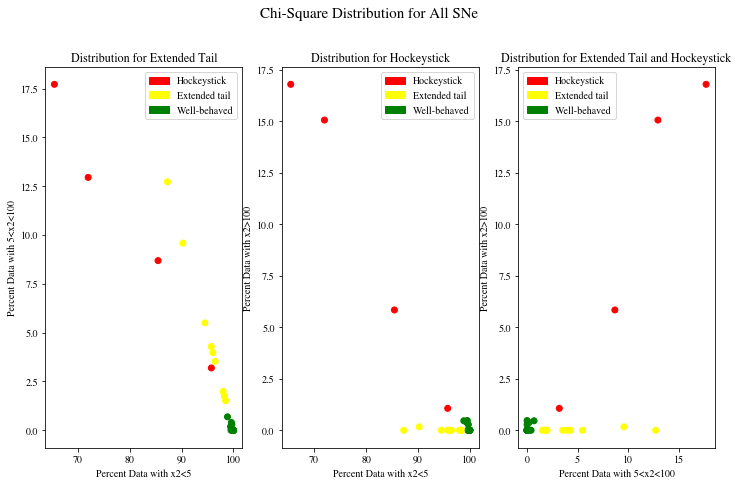

In [8]:
# divide light curve into 6 MJD regions: baseline (t0, t1, t2), SN (t0, t1, t2).
# for each MJD region, calculate the number of detections. If n < 50, disregard. If n > 50, continue.
# hockeystick: % data with x2>100
# extended tail: % data with 5<x2<100
# well-behaved: % data with x2<5

def get_region_table_plot_colors(regionstates):
    colors = []
    for state in regionstates.loc[[1,2,3,5,6,7],'state']:
        if state == 'hockeystick':
            colors.append('red')
        elif state == 'extended tail':
            colors.append('yellow')
        else:
            colors.append('green')
    return colors 

def get_regionstates_allsne_table_colors(val):
    if val == 'hockeystick':
        color = 'red'
    elif val == 'extended tail':
        color = 'yellow'
    elif val == 'well-behaved':
        color = 'green'
    else:
        color = 'white'
    return 'background-color: %s' % color

def get_ranges(info):
    baseline = np.where(info['lc'].t['MJD'] < info['mjdstart'])[0]
    aftersnstart = AnotB(info['lc'].getindices(),baseline)
    ranges = {}
    ranges[0] = baseline
    ranges[1] = AandB(baseline, np.where(info['lc'].t['MJD'] < tchange1)[0]) # b_t0
    ranges[2] = AandB(baseline, AandB(np.where(info['lc'].t['MJD'] > tchange1)[0], np.where(info['lc'].t['MJD'] < tchange2)[0])) # b_t1
    ranges[3] = AandB(baseline, np.where(info['lc'].t['MJD'] > tchange2)[0]) # b_t2
    ranges[4] = aftersnstart
    ranges[5] = AandB(aftersnstart, np.where(info['lc'].t['MJD'] < tchange1)[0]) # sn_t0
    ranges[6] = AandB(aftersnstart, AandB(np.where(info['lc'].t['MJD'] > tchange1)[0], np.where(info['lc'].t['MJD'] < tchange2)[0])) # sn_t1
    ranges[7] = AandB(aftersnstart, np.where(info['lc'].t['MJD'] > tchange2)[0]) # sn_t2
    return ranges

def get_region_table(info):
    regionstates = pdastrostatsclass(columns=['region','n','start_index','end_index','mjd_start','Phockeystick','Pextendedtail','Pwellbehaved','state'])
    regionstates.t['region'] = ['b','b_t0','b_t1','b_t2','sn','sn_t0','sn_t1','sn_t2']
    ranges = get_ranges(info)

    for index in range(0,len(ranges)):
        regionstates.t.loc[index,'n'] = len(ranges[index])

        if len(ranges[index] > 0): 
            regionstates.t.loc[index,'mjd_start'] = info['lc'].t.loc[ranges[index][0],'MJD']
            regionstates.t.loc[index,'start_index'] = ranges[index][0]
            regionstates.t.loc[index,'end_index'] = ranges[index][-1]
        else:
            regionstates.t.loc[index,'mjd_start'] = np.nan
            regionstates.t.loc[index,'start_index'] = np.nan
            regionstates.t.loc[index,'end_index'] = np.nan
        if len(ranges[index]) < 50:
            regionstates.t.loc[index,'Phockeystick'] = np.nan
            regionstates.t.loc[index,'Pextendedtail'] = np.nan
            regionstates.t.loc[index,'Pwellbehaved'] = np.nan
            regionstates.t.loc[index,'state'] = np.nan
            continue

        Phockeystick_i = AandB(ranges[index], np.where(info['lc'].t['chi/N']>=hockeystick_cut)[0])
        Pextendedtail_i = AandB(ranges[index], AandB(np.where(info['lc'].t['chi/N']>=extendedtail_cut)[0], np.where(info['lc'].t['chi/N']<hockeystick_cut)[0]))
        Pwellbehaved_i = AandB(ranges[index], np.where(info['lc'].t['chi/N']<extendedtail_cut)[0])

        regionstates.t.loc[index,'Phockeystick'] = 100.0*len(Phockeystick_i)/len(ranges[index])
        regionstates.t.loc[index,'Pextendedtail'] = 100.0*len(Pextendedtail_i)/len(ranges[index])
        regionstates.t.loc[index,'Pwellbehaved'] = 100.0*len(Pwellbehaved_i)/len(ranges[index])
        
        if(regionstates.t.loc[index,'Phockeystick'] > hockeystick_cut_pcutoff):
            regionstates.t.loc[index,'state'] = 'hockeystick'
        elif(regionstates.t.loc[index,'Pextendedtail'] > extendedtail_cut_pcutoff):
            regionstates.t.loc[index,'state'] = 'extended tail'
        else:
            regionstates.t.loc[index,'state'] = 'well-behaved'

    return regionstates

def get_region_table_loop(lc_info):
    regionstates_allsne = pd.DataFrame(columns=['tnsname','classification','b_t0','b_t1','b_t2','sn_t0','sn_t1','sn_t2'])
    
    # prelim plots of distribution for percent cut
    fig, axes = plt.subplots(nrows=1, ncols=3)
    et, hs, eths = axes.flatten()
    plt.suptitle('Chi-Square Distribution for All SNe',fontsize=15, y=1)
    et.set_title('Distribution for Extended Tail')
    et.set_ylabel('Percent Data with %d<x2<%d' % (extendedtail_cut, hockeystick_cut))
    et.set_xlabel('Percent Data with x2<%d' % extendedtail_cut)
    hs.set_title('Distribution for Hockeystick')
    hs.set_ylabel('Percent Data with x2>%d' % hockeystick_cut)
    hs.set_xlabel('Percent Data with x2<%d' % extendedtail_cut)
    eths.set_title('Distribution for Extended Tail and Hockeystick')
    eths.set_xlabel('Percent Data with %d<x2<%d' % (extendedtail_cut, hockeystick_cut))
    eths.set_ylabel('Percent Data with x2>%d' % hockeystick_cut)

    hockeystick_counter = 0
    extendedtail_counter = 0
    wellbehaved_counter = 0
    for index in range(0,len(lc_info.t)):
        # get region table
        regionstates = get_region_table(lc_info.t.loc[index])
        print('SN %s MJD region states w.r.t. PSF chi-square values:' % (lc_info.t.loc[index,'tnsname'])) 
        print(regionstates.t.to_string(),'\n')

        ix = [1,2,3,5,6,7] # don't count repeat b and sn regions

        hockeystick_counter += len(np.where(regionstates.t.loc[ix,'state']=='hockeystick')[0])
        extendedtail_counter += len(np.where(regionstates.t.loc[ix,'state']=='extended tail')[0])
        wellbehaved_counter += len(np.where(regionstates.t.loc[ix,'state']=='well-behaved')[0])

        # plot
        colors = get_region_table_plot_colors(regionstates.t)
        et.scatter(regionstates.t.loc[ix,'Pwellbehaved'], regionstates.t.loc[ix,'Pextendedtail'], c=colors)
        hs.scatter(regionstates.t.loc[ix,'Pwellbehaved'], regionstates.t.loc[ix,'Phockeystick'], c=colors)
        eths.scatter(regionstates.t.loc[ix,'Pextendedtail'], regionstates.t.loc[ix,'Phockeystick'], c=colors)

        # classify each region
        regionstates_allsne.loc[index,'tnsname'] = lc_info.t.loc[index,'tnsname']
        regionstates_allsne.loc[index,'classification'] = lc_info.t.loc[index,'classification']
        for i in range(0,len(regionstates.t['region'])):
            regionstates_allsne.loc[index,regionstates.t.loc[i,'region']] = regionstates.t.loc[i,'state']

        # update lc_info
        et_colname = 'Pextendedtail_'
        hs_colname = 'Phockeystick_'
        for i in range(0,4):
            lc_info.t.loc[index, et_colname+regionstates.t.loc[i,'region']] = regionstates.t.loc[i,'Pextendedtail']
            lc_info.t.loc[index, hs_colname+regionstates.t.loc[i,'region']] = regionstates.t.loc[i,'Phockeystick']
    
    print('Hockeystick ranges: %d\nExtended tail ranges: %d\nWell-behaved ranges: %d\n' % (hockeystick_counter, extendedtail_counter, wellbehaved_counter))
    
    # legends for plots of distribution for percent cut
    red = mpatches.Patch(color='red', label='Hockeystick')
    yellow = mpatches.Patch(color='yellow', label='Extended tail')
    green = mpatches.Patch(color='green', label='Well-behaved')
    et.legend(handles=[red, yellow, green])
    hs.legend(handles=[red, yellow, green])
    eths.legend(handles=[red, yellow, green])

    return regionstates_allsne, lc_info

regionstates_allsne = pdastrostatsclass(columns=['tnsname','classification','b_t0','b_t1','b_t2','sn_t0','sn_t1','sn_t2'])

print('Template changes at %d and %d MJD' % (tchange1,tchange2))
print('PSF chi-square cut for hockeystick classification: %d; PSF chi-square cut for extended tail classification: %d' % (hockeystick_cut,extendedtail_cut))
print('PSF chi-square hockeystick cut percent cutoff: %0.1f%%; PSF chi-square extended tail cut percent cutoff: %0.1f%%\n' % (hockeystick_cut_pcutoff, extendedtail_cut_pcutoff))
regionstates_allsne.t, lc_info = get_region_table_loop(lc_info)
print(lc_info.t)
regionstates_allsne.t.style.applymap(get_regionstates_allsne_table_colors)

### Step 5: Examine each region defined by the ATLAS template changes and its chi-squares in relation to S/N


Plotting S/N Histograms for Well-Behaved MJD Regions
Expected indices for this state: 2654
Expected 2 indices and found 2 indices for chi-square range  100 - None
Expected 0 indices and found 0 indices for chi-square range  5 - 100
Expected 2652 indices and found 2652 indices for chi-square range  None - 5

Plotting S/N Histograms for Extended Tail MJD Regions
Expected indices for this state: 114
Expected 0 indices and found 0 indices for chi-square range  100 - None
Expected 2 indices and found 2 indices for chi-square range  5 - 100
Expected 112 indices and found 112 indices for chi-square range  None - 5

Plotting S/N Histograms for Hockeystick MJD Regions
Expected indices for this state: 2338
Expected 322 indices and found 322 indices for chi-square range  100 - None
Expected 328 indices and found 328 indices for chi-square range  5 - 100
Expected 1688 indices and found 1688 indices for chi-square range  None - 5


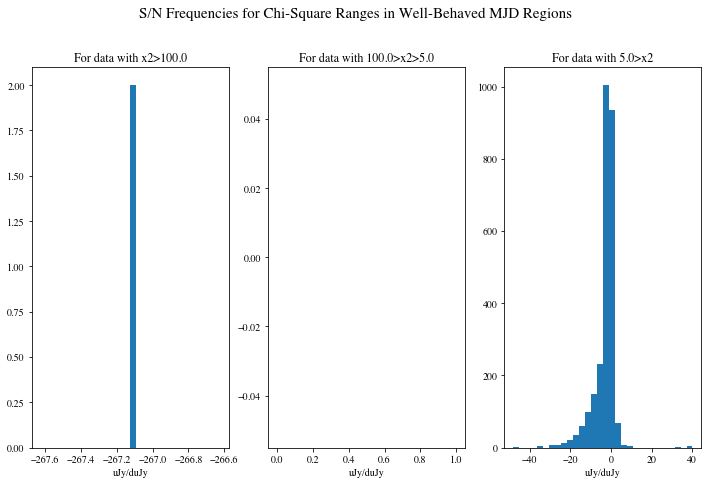

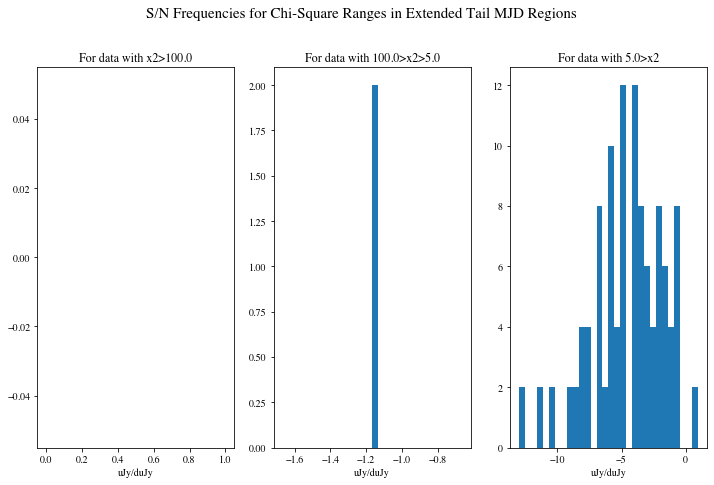

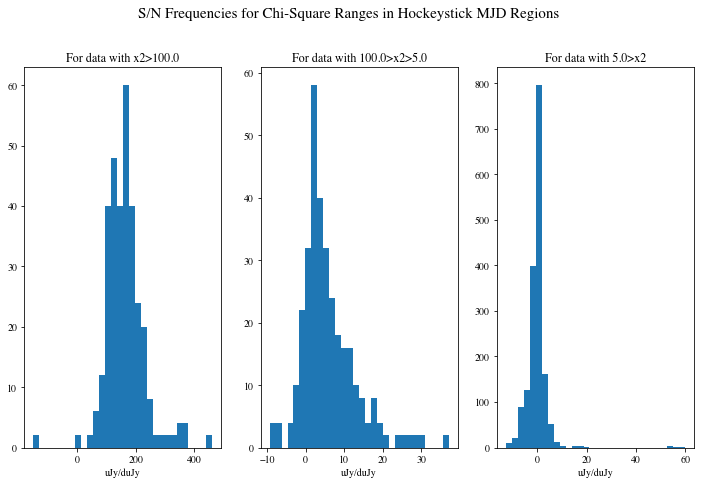

In [9]:
# for each well-behaved baseline region of all SNe, 3 histograms.
# histogram 1: S/N of all measurements with x2>hockeystick_cut.
# histogram 2: S/N of all measurements with hockeystick_cut>x2>extendedtail_cut.
# histogram 3: S/N of all measurements with extendedtail_cut>x2.
# repeat for each extended tail baseline region and for each hockeystick baseline region.

def get_state_expected_n(state):
    counter = 0
    for index in range(0,len(lc_info.t)):
        regionstates = get_region_table(lc_info.t.loc[index])
        for b_region_i in range(0,3):
            if regionstates.t.loc[b_region_i,'state'] == state:
                counter += regionstates.t.loc[b_region_i,'n']
    return counter

def get_state_x2_expected_n(state, x2_lowlim=None, x2_uplim=None):
    counter = 0
    for index in range(0,len(lc_info.t)):
        regionstates = get_region_table(lc_info.t.loc[index])
        for b_region_i in range(0,3):
            if regionstates.t.loc[b_region_i,'state'] == state:
                s = regionstates.t.loc[b_region_i,'start_index']
                e = regionstates.t.loc[b_region_i,'end_index']
                if not(x2_lowlim is None) and not(x2_uplim is None):
                    counter += len(AandB(np.where(lc_info.t.loc[index,'lc'].t.loc[range(s,e+1),'chi/N']>= x2_lowlim)[0], np.where(lc_info.t.loc[index,'lc'].t.loc[range(s,e+1),'chi/N']<= x2_uplim)[0]))
                elif not(x2_lowlim is None):
                    counter += len(np.where(lc_info.t.loc[index,'lc'].t.loc[range(s,e+1),'chi/N']>= x2_lowlim)[0])
                elif not(x2_uplim is None):
                    counter += len(np.where(lc_info.t.loc[index,'lc'].t.loc[range(s,e+1),'chi/N']<= x2_uplim)[0])
    return counter

def get_state_baseline_allsne(state):
    state_baseline_allsne = pdastrostatsclass()
    for index in range(0,len(lc_info.t)):
        #print('SN ', lc_info.t.loc[index,'tnsname'])
        regionstates = get_region_table(lc_info.t.loc[index])
        #print(regionstates.t.to_string())
        # for each baseline region, check if state matches and if so add to state_baseline_allsne table
        for b_region_i in range(0,3):
            #print(b_region_i,regionstates.t.loc[b_region_i,'state'])
            if regionstates.t.loc[b_region_i,'state'] == state:
                #print('passed, adding: ', regionstates.t.loc[b_region_i,'start_index'], regionstates.t.loc[b_region_i,'end_index'])
                # add measurements within that region to state_baseline_allsne table
                state_baseline_allsne.t = pd.concat([state_baseline_allsne.t, 
                                                    lc_info.t.loc[index,'lc'].t.loc[range(regionstates.t.loc[b_region_i,'start_index'], 1+regionstates.t.loc[b_region_i,'end_index'])]], 
                                                    ignore_index=True)
    state_baseline_allsne.t['uJy/duJy'] = state_baseline_allsne.t['uJy']/state_baseline_allsne.t['duJy']
    state_baseline_allsne.t = state_baseline_allsne.t.replace([np.inf, -np.inf], np.nan)

    return state_baseline_allsne

def plot_stn_hist(state, state_baseline_allsne, hist, x2_lowlim=None, x2_uplim=None):
    indices = state_baseline_allsne.ix_inrange(colnames=['chi/N'], lowlim=x2_lowlim, uplim=x2_uplim)
    print('Expected %d indices and found %d indices for chi-square range ' % (get_state_x2_expected_n(state,x2_lowlim,x2_uplim), len(indices)), x2_lowlim, '-', x2_uplim)

    #print(state_baseline_allsne.t.loc[indices, 'uJy/duJy'].to_string())
    hist.hist(state_baseline_allsne.t.loc[indices, 'uJy/duJy'], bins=30) #, range=(0,20))
    
    title = 'For data with '
    if not(x2_uplim is None): title += '%0.1f>' % x2_uplim
    title += 'x2'
    if not(x2_lowlim is None): title += '>%0.1f' % x2_lowlim
    hist.set_title(title)
    hist.set_xlabel('uJy/duJy')

def plot_region_stn_hist(state):
    print('\nPlotting S/N Histograms for %s MJD Regions' % state.title())
    state_baseline_allsne = get_state_baseline_allsne(state)
    #print(state_baseline_allsne.t)
    print('Expected indices for this state: %d' % get_state_expected_n(state))

    fig, axes = plt.subplots(nrows=1, ncols=3)
    plt.suptitle('S/N Frequencies for Chi-Square Ranges in %s MJD Regions' % state.title(), fontsize=15, y=1)
    hs, et, wb = axes.flatten()

    plot_stn_hist(state, state_baseline_allsne, hs, x2_lowlim=hockeystick_cut)
    plot_stn_hist(state, state_baseline_allsne, et, x2_lowlim=extendedtail_cut, x2_uplim=hockeystick_cut)
    plot_stn_hist(state, state_baseline_allsne, wb, x2_uplim=extendedtail_cut)


plot_region_stn_hist('well-behaved') 
plot_region_stn_hist('extended tail')
plot_region_stn_hist('hockeystick')

### Step 6: Recalculate cut limits for each SN based on contamination and other factors (to potentially replace Step 4)

In [10]:
# Enter the contamination limit (contamination = Nbad,kept/Nkept must be <= contam_lim%):
global contam_lim
contam_lim = 10.0

# Enter the loss limit (loss = Ngood,cut/Ngood must be >= loss_lim%):
global loss_lim
loss_lim = 10.0

# Enter the limit to prioritize (must be 'loss_lim' or 'contam_lim', based on which is more important):
global lim_to_prioritize
lim_to_prioritize = 'contam_lim'

# Enter the parameters for the chi-square cut (minimum cut, maximum cut, and step):
global cut_start
global cut_stop
global cut_step
cut_start = 5 # this is inclusive
cut_stop = 50 # this is inclusive
cut_step = 1

# Enter the signal-to-noise cut that will determine a "good" measurement from
# a "bad" measurement:
global stn_cut
stn_cut = 3


Cutting 2019vxm...
abs(uJy/duJy) cut at: 3.00 
x2 cut from 5.00 to 50.00 inclusive, with step size 1
Static chi square cut at 50: 16.31% cut for baseline
   PSF Chi-Square Cut    N Ngood Nbad Nkept Ncut Ngood,kept Ngood,cut Nbad,kept Nbad,cut  Pgood,kept  Pgood,cut  Pbad,kept   Pbad,cut  Ngood,kept/Ngood      Loss  Contamination
0                   5  981   652  329   664  317        596        56        68      261   60.754332   5.708461   6.931702  26.605505         91.411043  8.588957      10.240964
1                   6  981   652  329   693  288        614        38        79      250   62.589195   3.873598   8.053007  25.484200         94.171779  5.828221      11.399711
2                   7  981   652  329   715  266        627        25        88      241   63.914373   2.548420   8.970438  24.566769         96.165644  3.834356      12.307692
3                   8  981   652  329   738  243        635        17       103      226   64.729867   1.732926  10.499490  23.037717    

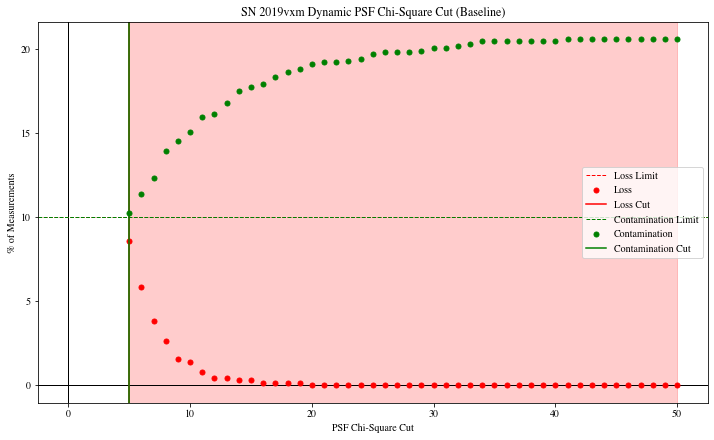

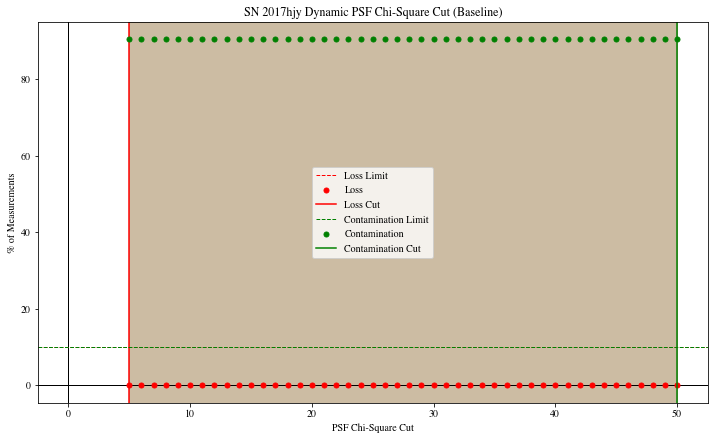

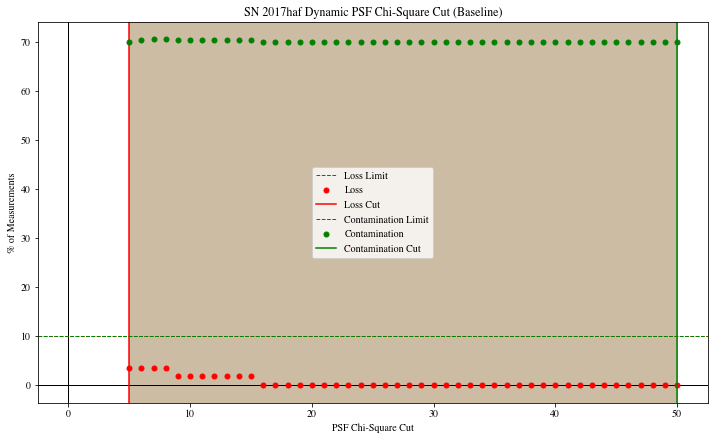

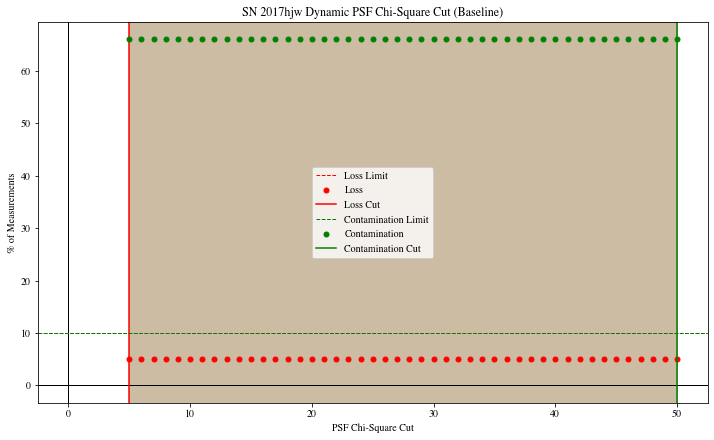

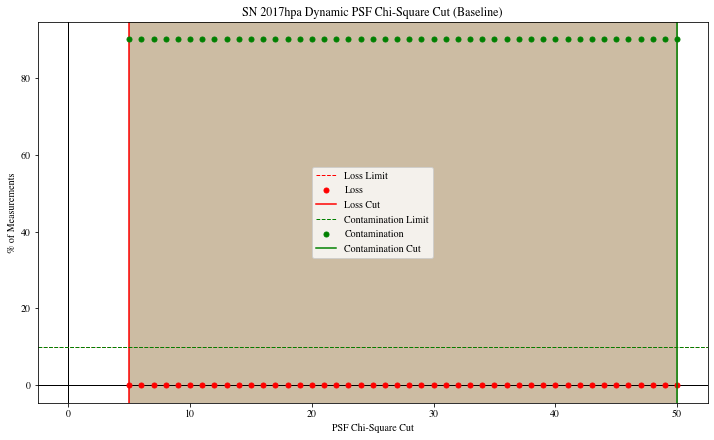

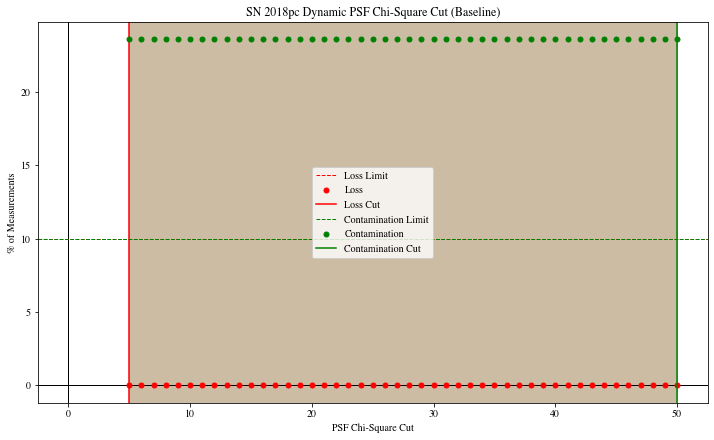

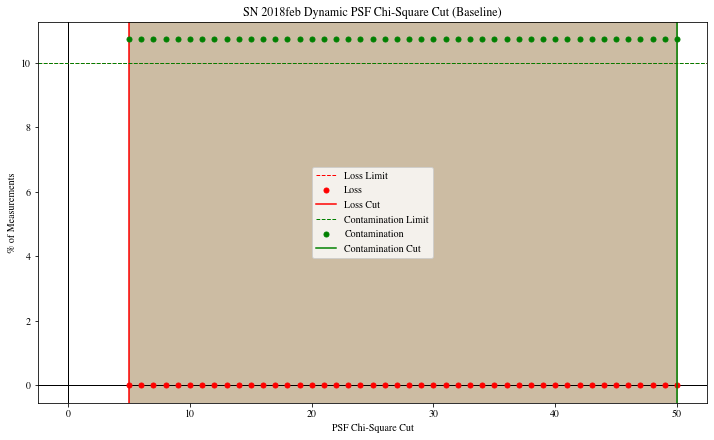

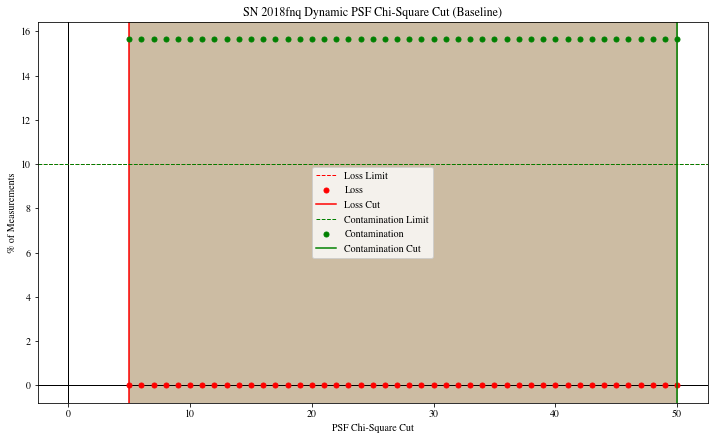

In [14]:
# 1. static cut at x2=50; get percent cut before and after mjdstart
# 2. for different x2 cuts decreasing from cut_stop and cut at stn_cut
#    and for only baseline calculate contam% and loss%

def plot_lim_cuts(info, lim_cuts, contam_lim_cut, loss_lim_cut, add2title=None):
    plt.figure()
    title = 'SN '+info['tnsname']+' Dynamic PSF Chi-Square Cut'
    if add2title is None:
        title += ' (Baseline)'
    else:
        title += add2title
    plt.title(title)
    plt.axhline(linewidth=1,color='k')
    plt.axvline(linewidth=1,color='k')
    plt.xlabel('PSF Chi-Square Cut')
    plt.ylabel('% of Measurements')

    plt.axhline(loss_lim,linewidth=1,color='r',linestyle='--',label='Loss Limit')
    sp, loss, dloss = dataPlot(lim_cuts.t['PSF Chi-Square Cut'], lim_cuts.t['Loss'])
    matlib.setp(loss,ms=5,color='r',marker='o',label='Loss')
    plt.axvline(x=loss_lim_cut,color='r',label='Loss Cut')
    plt.axvspan(loss_lim_cut, 50, alpha=0.2, color='r')

    plt.axhline(contam_lim,linewidth=1,color='g',linestyle='--',label='Contamination Limit')
    sp, contam, dcontam = dataPlot(lim_cuts.t['PSF Chi-Square Cut'], lim_cuts.t['Contamination'])
    matlib.setp(contam,ms=5,color='g',marker='o',label='Contamination')
    plt.axvline(x=contam_lim_cut,color='g',label='Contamination Cut')
    plt.axvspan(5, contam_lim_cut, alpha=0.2, color='g')
    
    plt.legend()

def get_lim_cuts(lim_cuts):
    contam_lim_cut = None
    loss_lim_cut = None
    contam_case = None
    loss_case = None

    sortby_loss = lim_cuts.t.iloc[(lim_cuts.t['Loss']).argsort()].reset_index()
    min_loss = sortby_loss.loc[0,'Loss']
    max_loss = sortby_loss.loc[len(sortby_loss)-1,'Loss']
    # if all loss below lim, loss_lim_cut is min cut
    if min_loss < loss_lim and max_loss < loss_lim:
        loss_case = 'below lim'
        loss_lim_cut = lim_cuts.t.loc[0,'PSF Chi-Square Cut']
    else:
        # else if all loss above lim, loss_lim_cut is min cut with min% loss
        if min_loss > loss_lim and max_loss > loss_lim:
            loss_case = 'above lim'
            a = np.where(lim_cuts.t['Loss'] == min_loss)[0]
        # else if loss crosses lim at some point, loss_lim_cut is min cut with max% loss <= loss_lim
        else:
            loss_case = 'crosses lim'
            valid_cuts = sortby_loss[sortby_loss['Loss'] <= loss_lim]
            a = np.where(lim_cuts.t['Loss'] == valid_cuts.loc[len(valid_cuts)-1,'Loss'])[0]
        # sort those indices by cuts
        b = lim_cuts.t.iloc[a]
        c = b.iloc[(b['PSF Chi-Square Cut']).argsort()].reset_index()
        loss_lim_cut = c.loc[0,'PSF Chi-Square Cut']

    sortby_contam = lim_cuts.t.iloc[(lim_cuts.t['Contamination']).argsort()].reset_index()
    min_contam = sortby_contam.loc[0,'Contamination']
    max_contam = sortby_contam.loc[len(sortby_contam)-1,'Contamination']
    # if all contam below lim, contam_lim_cut is max cut
    if min_contam < contam_lim and max_contam < contam_lim:
        contam_case = 'below lim'
        contam_lim_cut = lim_cuts.t.loc[len(lim_cuts.t)-1,'PSF Chi-Square Cut']
    else:
        # else if all contam above lim, contam_lim_cut is max cut with min% contam
        if min_contam > contam_lim and max_contam > contam_lim:
            contam_case = 'above lim'
            a = np.where(lim_cuts.t['Contamination'] == min_contam)[0]
        # else if contam crosses lim at some point, contam_lim_cut is max cut with max% contam <= contam_lim
        else:
            contam_case = 'crosses lim'
            valid_cuts = sortby_contam[sortby_contam['Contamination'] <= contam_lim]
            a = np.where(lim_cuts.t['Contamination'] == valid_cuts.loc[len(valid_cuts)-1,'Contamination'])[0]
        # sort those indices by cuts
        b = lim_cuts.t.iloc[a]
        c = b.iloc[(b['PSF Chi-Square Cut']).argsort()].reset_index()
        contam_lim_cut = c.loc[len(c)-1,'PSF Chi-Square Cut']

    return contam_lim_cut, loss_lim_cut, contam_case, loss_case

def choose_btwn_lim_cuts(contam_lim_cut, loss_lim_cut, contam_case, loss_case):
    # case 1 and 1: final_cut = 5
    # case 1 and 2: take limit of case 2
    # case 1 and 3: take limit of case 3
    # case 2 and 2: print lims don't work
    # case 2 and 3: choose_btwn_lim_cuts
    # case 3 and 3: choose_btwn_lim_cuts

    case1 = loss_case == 'below lim' or contam_case == 'below lim'
    case2 = loss_case == 'above lim' or contam_case == 'above lim'
    case3 = loss_case == 'crosses lim' or contam_case == 'crosses lim'

    final_cut = None
    if case1 and not case2 and not case3: # 1 and 1
        print('Valid chi-square cut range from %d to %d! Setting to 5...' % (loss_lim_cut, contam_lim_cut))
        final_cut = 5
    elif case1: # 1
        if case2: # and 2
            if loss_case == 'above lim':
                print('WARNING: contam_lim_cut <= %d falls below limit %0.2f%%, but loss_lim_cut >= %d falls above limit %0.2f%%! Setting to %d...' % (contam_lim_cut, contam_lim, loss_lim_cut, loss_lim, loss_lim_cut))
                final_cut = loss_lim_cut
            else:
                print('WARNING: loss_lim_cut <= %d falls below limit %0.2f%%, but contam_lim_cut >= %d falls above limit %0.2f%%! Setting to %d...' % (loss_lim_cut, loss_lim, contam_lim_cut, contam_lim, contam_lim_cut))
                final_cut = contam_lim_cut
        else: # and 3
            if loss_case == 'crosses lim':
                print('Contam_lim_cut <= %d falls below limit %0.2f%% and loss_lim_cut >= %d crosses limit %0.2f%%, setting to %d...' % (contam_lim_cut, contam_lim, loss_lim_cut, loss_lim, loss_lim_cut))
                final_cut = loss_lim_cut
            else:
                print('Loss_lim_cut <= %d falls below limit %0.2f%% and contam_lim_cut >= %d crosses limit %0.2f%%, setting to %d...' % (loss_lim_cut, loss_lim, contam_lim_cut, contam_lim, contam_lim_cut))
                final_cut = contam_lim_cut
    elif case2 and not case3: # 2 and 2
        print('ERROR: chi-square loss_lim_cut >= %d and contam_lim_cut <= %d both fall above limits %0.2f%% and %0.2f%%! Try setting less strict limits. Setting final cut to nan.' % (loss_lim_cut, contam_lim_cut, loss_lim, contam_lim))
        final_cut = np.nan
    else: # 2 and 3 or 3 and 3
        if loss_lim_cut > contam_lim_cut:
            print('WARNING: chi-square loss_lim_cut >= %d and contam_lim_cut <= %d do not overlap! ' % (loss_lim_cut, contam_lim_cut))
            if lim_to_prioritize == 'contam_lim':
                print('Prioritizing %s and setting to %d...' % (lim_to_prioritize, contam_lim_cut))
                final_cut = contam_lim_cut
            else:
                print('Prioritizing %s and setting to %d... ' % (lim_to_prioritize, loss_lim_cut))
                final_cut = loss_lim_cut
        else:
            print('Valid chi-square cut range from %d to %d! ' % (loss_lim_cut, contam_lim_cut))
            if lim_to_prioritize == 'contam_lim':
                print('Prioritizing %s and setting to %d... ' % (lim_to_prioritize, loss_lim_cut))
                final_cut = loss_lim_cut
            else:
                print('Prioritizing %s and setting to %d... ' % (lim_to_prioritize, contam_lim_cut))
                final_cut = contam_lim_cut
    return final_cut

def get_lim_cuts_table(info, indices=None):
    print('\nCutting %s...' % info['tnsname'])
    print('abs(uJy/duJy) cut at: %0.2f \nx2 cut from %0.2f to %0.2f inclusive, with step size %d' % (stn_cut,cut_start,cut_stop,cut_step))

    lim_cuts = pdastrostatsclass(columns=['PSF Chi-Square Cut', 'N', 'Ngood', 'Nbad', 'Nkept', 'Ncut', 'Ngood,kept', 'Ngood,cut', 'Nbad,kept', 'Nbad,cut',
                                        'Pgood,kept', 'Pgood,cut', 'Pbad,kept', 'Pbad,cut', 'Ngood,kept/Ngood', 'Loss', 'Contamination'])

    if indices is None:
        indices = np.where(info['lc'].t['MJD'] < info['mjdstart'])[0]
    
    # static cut at x2=50
    x2cut_50 = np.where(info['lc'].t['chi/N'] < 50)[0]
    print('Static chi square cut at 50: %0.2f%% cut for baseline' % (100*len(AnotB(indices,x2cut_50))/len(indices)))

    # good baseline measurement indices
    b_stncut_i = AandB(indices, np.where(abs(info['lc'].t['uJy/duJy']) < stn_cut)[0])
    # for different x2 cuts decreasing from 50 and cut at abs(s/n)=stn_cut
    for cut in range(cut_start,cut_stop+1,cut_step):
        # kept baseline measurement indices
        b_x2cut_i = AandB(indices, np.where(info['lc'].t['chi/N'] < cut)[0])

        df = pd.DataFrame([[cut,
                            len(indices), # N
                            len(b_stncut_i), # Ngood
                            len(AnotB(indices,b_stncut_i)), # Nbad
                            len(b_x2cut_i), # Nkept
                            len(AnotB(indices,b_x2cut_i)), # Ncut
                            len(AandB(b_stncut_i,b_x2cut_i)), # Ngood,kept
                            len(AnotB(b_stncut_i,b_x2cut_i)), # Ngood,cut
                            len(AnotB(b_x2cut_i,b_stncut_i)), # Nbad,kept
                            len(AandB(AnotB(indices,b_stncut_i),AnotB(indices,b_x2cut_i))), # Nbad,cut
                            100*len(AandB(b_stncut_i,b_x2cut_i))/len(indices), # Ngood,kept/Nbaseline
                            100*len(AnotB(b_stncut_i,b_x2cut_i))/len(indices), # Ngood,cut/Nbaseline 
                            100*len(AnotB(b_x2cut_i,b_stncut_i))/len(indices), # Nbad,kept/Nbaseline
                            100*len(AandB(AnotB(indices,b_stncut_i),AnotB(indices,b_x2cut_i)))/len(indices), # Nbad,cut/Nbaseline
                            100*len(AandB(b_stncut_i,b_x2cut_i))/len(b_stncut_i), # Ngood,kept/Ngood
                            100*len(AnotB(b_stncut_i,b_x2cut_i))/len(b_stncut_i), # Ngood,cut/Ngood = Loss
                            100*len(AnotB(b_x2cut_i,b_stncut_i))/len(b_x2cut_i)]], # Nbad,kept/Nkept = Contamination
                            columns=['PSF Chi-Square Cut', 'N', 'Ngood', 'Nbad', 'Nkept', 'Ncut', 'Ngood,kept', 'Ngood,cut', 'Nbad,kept', 'Nbad,cut',
                                        'Pgood,kept', 'Pgood,cut', 'Pbad,kept', 'Pbad,cut', 'Ngood,kept/Ngood', 'Loss', 'Contamination'])
        lim_cuts.t = pd.concat([lim_cuts.t,df],ignore_index=True)
    return lim_cuts

def get_lim_cuts_loop(lc_info):
    for index in range(0,len(lc_info.t)):
        lim_cuts = get_lim_cuts_table(lc_info.t.loc[index])
        #print(lim_cuts.t.to_string())

        contam_lim_cut, loss_lim_cut, contam_case, loss_case = get_lim_cuts(lim_cuts)
        print('Contamination cut according to given contam_limit: ',contam_lim_cut,'\nLoss cut according to given loss_limit: ',loss_lim_cut)
        lc_info.t.loc[index,'contam_case'] = contam_case
        lc_info.t.loc[index,'loss_case'] = loss_case
        lc_info.t.loc[index,'contam_lim_cut'] = contam_lim_cut
        lc_info.t.loc[index,'loss_lim_cut'] = loss_lim_cut

        final_cut = choose_btwn_lim_cuts(contam_lim_cut, loss_lim_cut, contam_case, loss_case)
        lc_info.t.loc[index,'final_cut'] = final_cut
        
        if np.isnan(final_cut):
            print('Final chi-square cut could not be determined.')
            lc_info.t.loc[index,'Pcontamination'] = np.nan
            lc_info.t.loc[index,'Ploss'] = np.nan
        else:
            lc_info.t.loc[index,'Pcontamination'] = lim_cuts.t.loc[np.where(lim_cuts.t['PSF Chi-Square Cut']==final_cut)[0][0],'Contamination']
            lc_info.t.loc[index,'Ploss'] = lim_cuts.t.loc[np.where(lim_cuts.t['PSF Chi-Square Cut']==final_cut)[0][0],'Loss']
            print('Final chi-square cut is %d, with %0.2f%% contamination and %0.2f%% loss.' % (final_cut, lc_info.t.loc[index,'Pcontamination'], lc_info.t.loc[index,'Ploss']))

        plot_lim_cuts(lc_info.t.loc[index], lim_cuts, contam_lim_cut, loss_lim_cut)

    return lc_info

if lim_to_prioritize != 'loss_lim' and lim_to_prioritize != 'contam_lim':
    print("ERROR: lim_to_prioritize must be 'loss_lim' or 'contam_lim'!")
    sys.exit()

lc_info.t['contam_lim_cut'] = None
lc_info.t['loss_lim_cut'] = None

lc_info = get_lim_cuts_loop(lc_info)
print('\n',lc_info.t.to_string())

### Step 7: Plot Pextendedtail and Phockeystick against Contamination and Loss Limits


   region    n start_index end_index     mjd_start Phockeystick Pextendedtail Pwellbehaved        state
0      b  981           0       980  57914.530063    16.207951     16.106014    67.686035  hockeystick
1   b_t0  649           0       648  57914.530063    16.795069     17.719569    65.485362  hockeystick
2   b_t1  332         649       980  58430.257787    15.060241     12.951807    71.987952  hockeystick
3   b_t2    0         NaN       NaN           NaN          NaN           NaN          NaN          NaN
4     sn  720         981      1700  58818.234167     5.972222      9.305556    84.722222  hockeystick
5  sn_t0    0         NaN       NaN           NaN          NaN           NaN          NaN          NaN
6  sn_t1   18         981       998  58818.234167          NaN           NaN          NaN          NaN
7  sn_t2  702         999      1700  58910.610803     5.840456      8.689459    85.470085  hockeystick
Getting limits for regions from i=0 to i=648...

Cutting 2019vxm...
abs

"\nred = mpatches.Patch(color='red', label='Contamination Cut')\ngreen = mpatches.Patch(color='green', label='Loss Cut')\net.legend(handles=[red, green])\nhs.legend(handles=[red, green])\n"

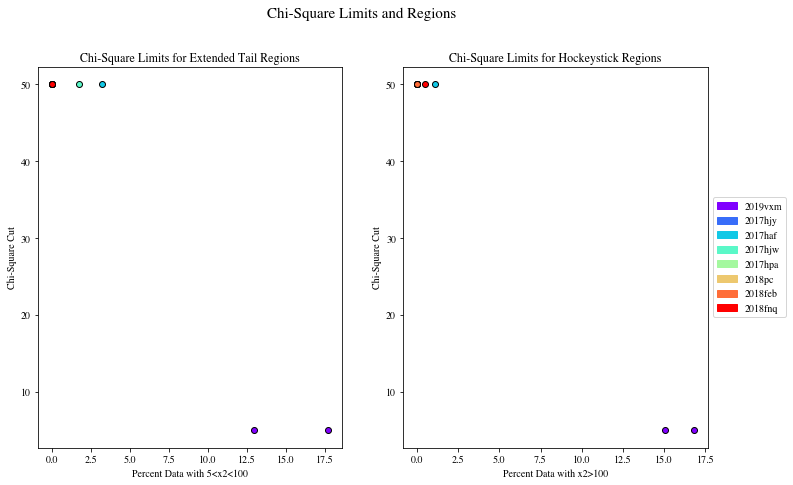

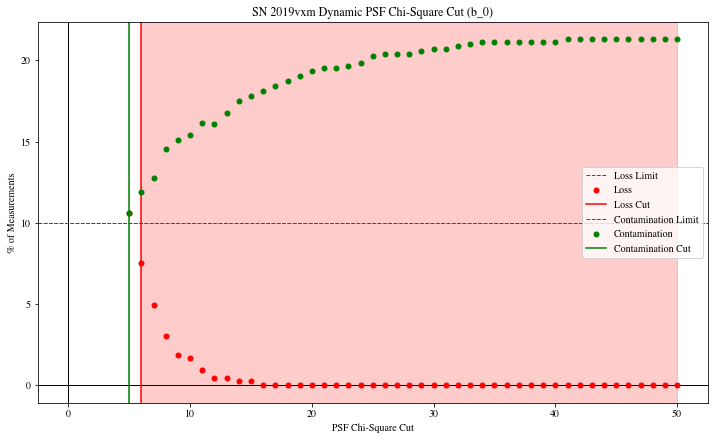

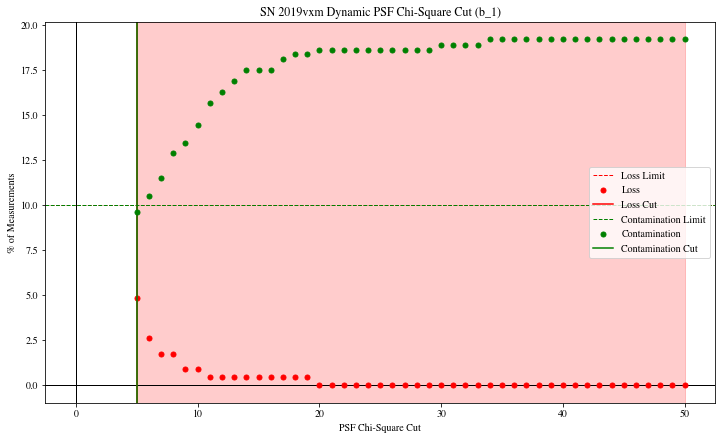

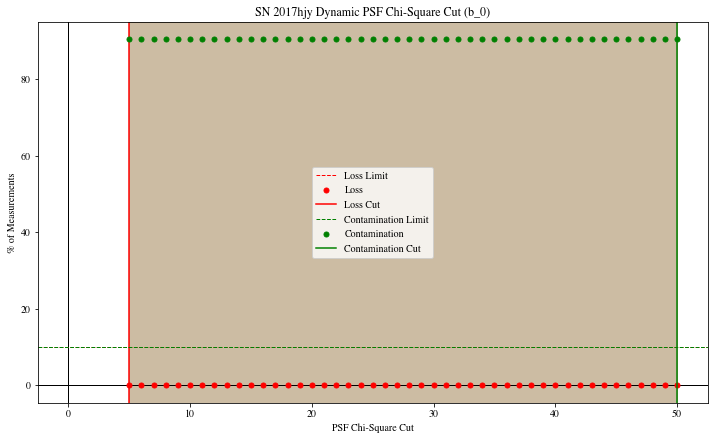

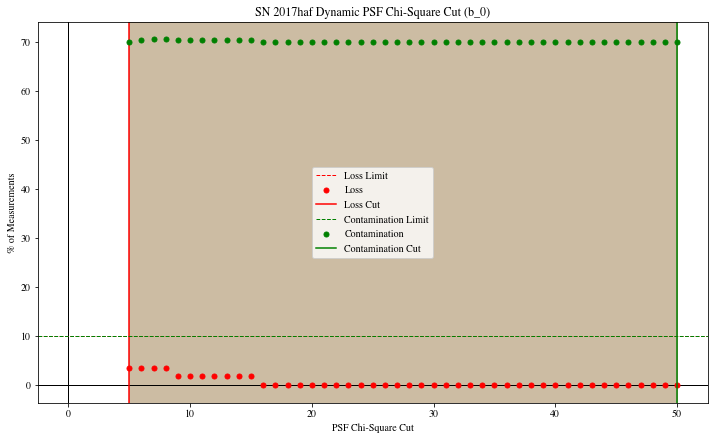

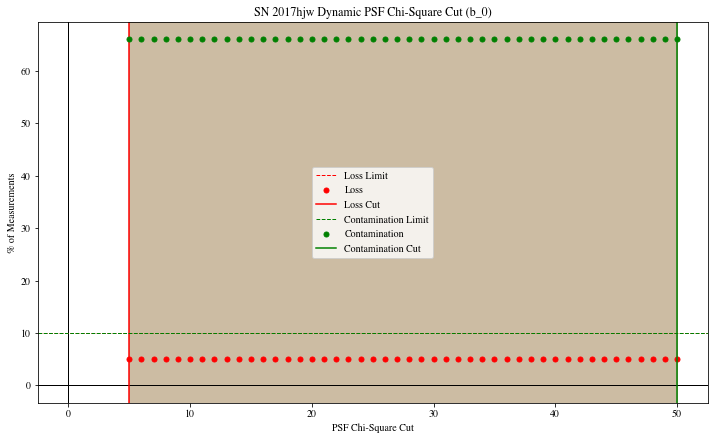

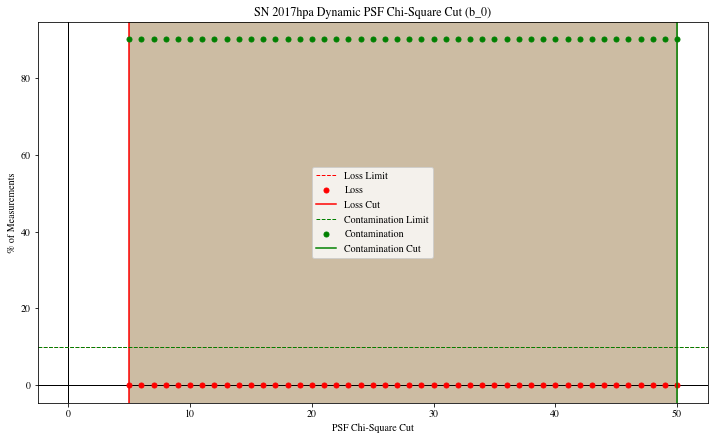

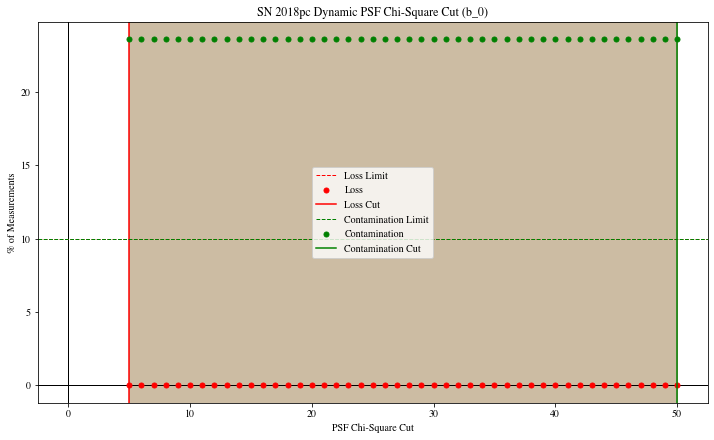

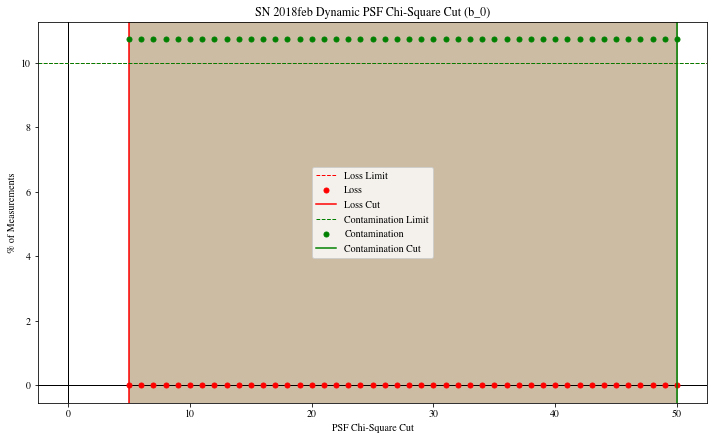

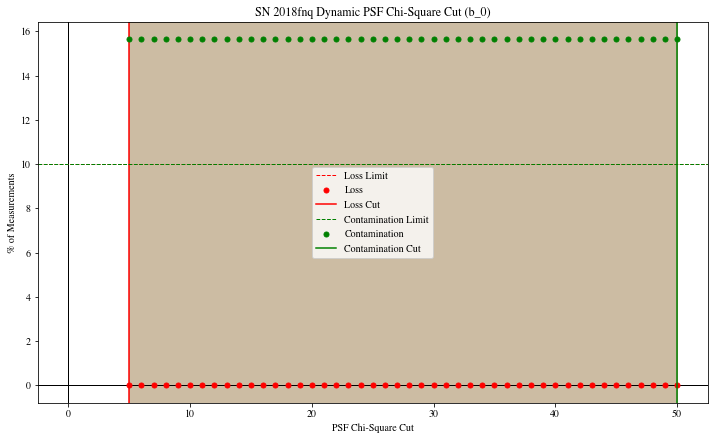

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2)
et, hs = axes.flatten()
plt.suptitle('Chi-Square Limits and Regions',fontsize=15, y=1)
et.set_title('Chi-Square Limits for Extended Tail Regions')
et.set_xlabel('Percent Data with %d<x2<%d' % (extendedtail_cut, hockeystick_cut))
et.set_ylabel('Chi-Square Cut')
hs.set_title('Chi-Square Limits for Hockeystick Regions')
hs.set_xlabel('Percent Data with x2>%d' % hockeystick_cut)
hs.set_ylabel('Chi-Square Cut')

color = iter(plt.cm.rainbow(np.linspace(0, 1, len(lc_info.t))))

tnsnames = []
for index in range(0,len(lc_info.t)):
    c = next(color)
    tnsnames.append(mpatches.Patch(color=c, label=lc_info.t.loc[index,'tnsname']))

    #et.scatter(lc_info.t.loc[index,'Pextendedtail_b'], lc_info.t.loc[index,'final_cut'], color='b')
    #hs.scatter(lc_info.t.loc[index,'Phockeystick_b'], lc_info.t.loc[index,'final_cut'], color='b')

    regionstates = get_region_table(lc_info.t.loc[index])
    print('\n',regionstates.t.to_string())

    for j in [1,2,3]:
        if np.isnan(regionstates.t.loc[j,'start_index']) or np.isnan(regionstates.t.loc[j,'end_index']):
            continue

        print('Getting limits for regions from i=%d to i=%d...' % (regionstates.t.loc[j,'start_index'], regionstates.t.loc[j,'end_index']))
        lim_cuts = get_lim_cuts_table(lc_info.t.loc[index], indices=range(regionstates.t.loc[j,'start_index'],regionstates.t.loc[j,'end_index']+1))
        print(lim_cuts.t.to_string())

        contam_lim_cut, loss_lim_cut, contam_case, loss_case = get_lim_cuts(lim_cuts)
        print('Contamination cut according to given contam_limit: ',contam_lim_cut,'\nLoss cut according to given loss_limit: ',loss_lim_cut)
        final_cut = choose_btwn_lim_cuts(contam_lim_cut, loss_lim_cut, contam_case, loss_case)

        if np.isnan(final_cut):
            print('Final cut: ',final_cut)
        else:
            print('Final chi-square cut: %d, with %0.2f%% contamination and %0.2f%% loss.' % (final_cut, lim_cuts.t.loc[np.where(lim_cuts.t['PSF Chi-Square Cut']==final_cut)[0][0],'Contamination'], lim_cuts.t.loc[np.where(lim_cuts.t['PSF Chi-Square Cut']==final_cut)[0][0],'Loss']))

        et.scatter(regionstates.t.loc[j,'Pextendedtail'], final_cut, color=c, edgecolors='black') #, label='%s b_%d'%(lc_info.t.loc[index,'tnsname'],j-1))
        hs.scatter(regionstates.t.loc[j,'Phockeystick'], final_cut, color=c, edgecolors='black') #, label='%s b_%d'%(lc_info.t.loc[index,'tnsname'],j-1))

        plot_lim_cuts(lc_info.t.loc[index], lim_cuts, contam_lim_cut, loss_lim_cut, add2title=' (b_%d)'%(j-1))

#et.legend()
hs.legend(handles=tnsnames, loc='center left', bbox_to_anchor=(1, 0.5))

"""
red = mpatches.Patch(color='red', label='Contamination Cut')
green = mpatches.Patch(color='green', label='Loss Cut')
et.legend(handles=[red, green])
hs.legend(handles=[red, green])
"""